## Notebook showing example of plotting demand against supply


In [ ]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

In [103]:
from pathlib import Path
import sys
import json


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


PROJECT_ROOT = Path().home() 
USER_ROOT = Path().home() / 'work'

sys.path.append(str(USER_ROOT / 'patientflow' / 'src' / 'patientflow'))
sys.path.append(str(USER_ROOT / 'patientflow' / 'functions'))


data_path = Path(USER_ROOT / 'ed-predictor' / 'data-raw')

media_file_path = USER_ROOT / 'patientflow' / 'notebooks' / 'img'
media_file_path.mkdir(parents=True, exist_ok=True)

from viz.prob_dist_plot import prob_dist_plot
from plot_pipeline import create_colour_dict
spec_colour_dict = create_colour_dict()

In [90]:
spec_colour_dict

{'single': {'medical': '#ED7D31',
  'surgical': '#70AD47',
  'haem/onc': '#FFC000',
  'paediatric': '#5B9BD5',
  'all': '#44546A',
  'window': '#A9A9A9'},
 'spectrum': {'medical': <matplotlib.colors.LinearSegmentedColormap at 0x7f61b6556e10>,
  'surgical': <matplotlib.colors.LinearSegmentedColormap at 0x7f61b636e810>,
  'haem/onc': <matplotlib.colors.LinearSegmentedColormap at 0x7f61b636eb90>,
  'paediatric': <matplotlib.colors.LinearSegmentedColormap at 0x7f61b636e9d0>,
  'all': <matplotlib.colors.LinearSegmentedColormap at 0x7f61b636e990>,
  'window': <matplotlib.colors.LinearSegmentedColormap at 0x7f61b636eb10>}}


### Create fictional distributions

In [107]:
import numpy as np
import pandas as pd
from scipy.stats import poisson
from scipy.signal import convolve

# Parameters for the Poisson distributions
size = 50    # Size of the distributions

# Generate the Poisson distributions
x = np.arange(size)
poisson1 = poisson.pmf(x, 1) # in ED now
poisson2 = poisson.pmf(x, 2) # yta
poisson3 = poisson.pmf(x, 5) # discharges

# Create DataFrames for each Poisson distribution
ed = pd.DataFrame(data={'agg_proba': poisson1}, index=x)
yta = pd.DataFrame(data={'agg_proba': poisson2}, index=x)

# Function to compute the combined probabilities
def compute_combined_probabilities(df1, df2, add = True):
    combined_probs = {}
    for i in df1.index:
        # print(i)
        for j in df2.index:
            if add:
                new_index = i + j
            else:
                new_index = i - j
            prob = df1.loc[i, 'agg_proba'] * df2.loc[j, 'agg_proba']
            # print(j)
            # print(combined_probs)
            if new_index in combined_probs:
                combined_probs[new_index] += prob
            else:
                combined_probs[new_index] = prob
    
    return pd.DataFrame(list(combined_probs.items()), columns=['index', 'agg_proba']).set_index('index')

# Compute the combined probabilities
demand = compute_combined_probabilities(ed, yta, add = True)

supply = pd.DataFrame(data={'agg_proba': poisson3}, index=x)
netposition = compute_combined_probabilities(demand, supply, add = False)



In [158]:
directory_path = media_file_path / 'supply_demand_examples'
directory_path.mkdir(parents=True, exist_ok=True)
directory_path

PosixPath('/home/jovyan/work/patientflow/notebooks/img/supply_demand_examples')

In [149]:
def prob_dist_plot(prob_dist_data, title_, directory_path = None, figsize = (6,3), include_titles = False, truncate_at_beds=20, text_size = None, bar_colour='#5B9BD5', file_name = None, min_beds_lines = None):
            
    plt.figure(figsize=figsize)
    
    if not file_name:
        file_name = title_.replace(' ', '_').replace('/n', '_').replace('%', 'percent') + '.png'
    plt.bar(prob_dist_data.index, 
            prob_dist_data['agg_proba'],
            color=bar_colour)
    
    # plt.xlim(-0.5, truncate_at_beds + 0.5)
    # plt.xticks(np.arange(0, truncate_at_beds + 1, 5))  # Set x-axis ticks at every 5 units

    if min_beds_lines:

        colors = itertools.cycle(plt.cm.gray(np.linspace(0.3, 0.7, len(min_beds_lines))))

        for point in min_beds_lines:
            plt.axvline(x=min_beds_lines[point], linestyle='--', linewidth=2, color=next(colors), label=f'{point*100:.0f}% probability')

        plt.legend(loc='upper right')
    
    if text_size:

        plt.tick_params(axis='both', which='major', labelsize=text_size)
    
    if include_titles:
        
        plt.title(title_, fontsize = text_size)
        plt.xlabel('Number of beds')
        plt.ylabel('Probability')

    plt.tight_layout()
    
    if directory_path:
        plt.savefig(directory_path / file_name.replace(' ','_'), dpi=300)
    plt.show()

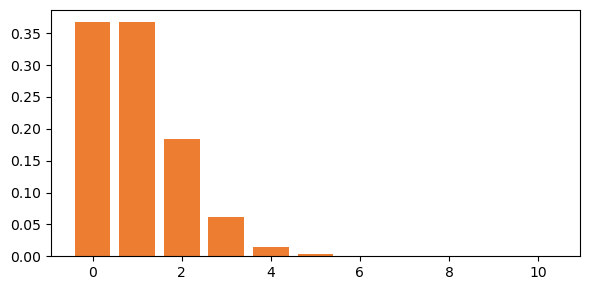

In [159]:
prob_dist_plot(prob_dist_data=ed.loc[0:10], title_='Patients in ED', 
                   directory_path=directory_path, 
               # figsize=figsize_global, text_size=20, 
                   # file_name = 'Figure c', 
                   truncate_at_beds = 10,
                  bar_colour = spec_colour_dict['single']['medical'])

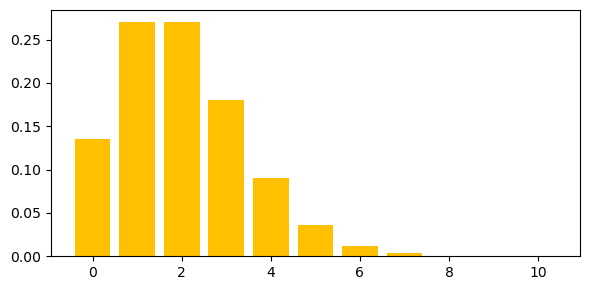

In [160]:
prob_dist_plot(prob_dist_data=yta.loc[0:10], title_='Patients yet to arrive', 
                   directory_path=directory_path, 
                   # file_name = 'Figure c', 
                   truncate_at_beds = 10,
                  bar_colour = spec_colour_dict['single']['haem/onc'])

<Figure size 600x300 with 0 Axes>

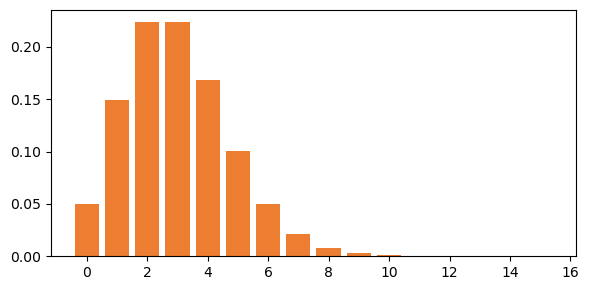

In [161]:
prob_dist_data = demand
plt.figure(figsize=(6,3))
truncate_at_ = 40

prob_dist_plot(prob_dist_data=demand.loc[0:15], title_='Total demand', 
                   directory_path=directory_path, 
                   # file_name = 'Figure c', 
                   truncate_at_beds = 15,
                  bar_colour = spec_colour_dict['single']['medical'])

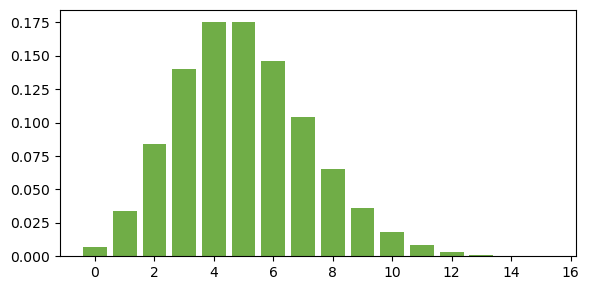

In [162]:
prob_dist_plot(prob_dist_data=supply.loc[0:15], title_='Discharges', 
                   directory_path=directory_path, 
                   # file_name = 'Figure c', 
                   truncate_at_beds = 15,
                  bar_colour = spec_colour_dict['single']['surgical'])

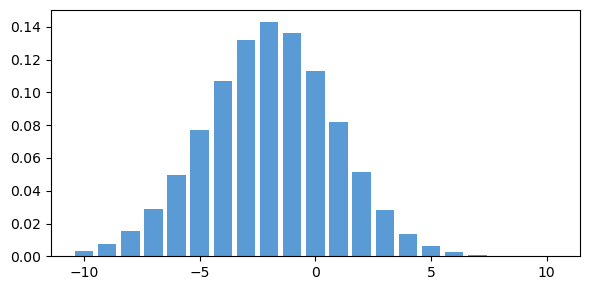

In [163]:
prob_dist_plot(prob_dist_data=netposition.sort_index().loc[-10:10], title_='Net position', 
                   directory_path=directory_path, 
                   # file_name = 'Figure c', 
                   truncate_at_beds = 15,
                  bar_colour = spec_colour_dict['single']['paediatric'])